In [1]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Predicting Ridership per City from Various Financial Parameters

We implement a linear model including various statistics from the Department of Transport. The parameters selected were those a city would have the most authority and influence over. For example, the city's transit agency can decide how much to spend on administration versus vehicle maintenance. A city could also request more federal or state funding as well as increase local funding to a transit agency. Parameters that were not included were totals as those are not specific enough to provide advice to a city of what could be different. Several parameters were also not included because they highly correlated with each other. For example, fare revenue will correlate positively with ridership because the more passenger the more fares collected. Parameters like Vehicle Revenue Hours and Vehicle Revenue miles are also closely linked so only one was selected to be included in the model.

Below we demonstrate how we also narrow down these parameters. We implement LASSO regression to determine which coefficients are zero and thus do not contribute to the fitting substantially. We gather all the statistics available and print how many times for each of the cities is the coefficient set to zero:

In [2]:
def combine_city_data(city_code, dfs, names):
    """
    Generate a single DataFrame with data from all years for one city.
    """
    data_rows = [df.loc[city_code] for df in dfs]
    all_data = pd.concat(data_rows, axis=1)
    all_data.columns = names
    all_data.index.name = 'Year'
    return all_data



def import_training_data(filename):
    return pd.read_csv('../data/train/%s' % filename, index_col='UACE Code', dtype={'UACE Code': str})


def import_testing_data(filename):
    return pd.read_csv('../data/test/%s' % filename, index_col='UACE Code', dtype={'UACE Code': str})

In [3]:
city_info = pd.read_csv('../data/Cities.csv', index_col='UACE Code', dtype={'UACE Code': str})

xnames = ['Year', 'VRH_percap',  'TotalFund_infladj_percap', 'FedFund_frac', 'StateFund_frac', 'LocalFund_frac', 'CapFund_infladj_percap', 'OpFund_infladj_percap', 'OpFund_frac', 'OpExp_Total_infladj_percap', 'OpExp_GA_frac', 'OpExp_VM_frac', 'OpExp_VO_frac']

coefficients_array = np.zeros((city_info.shape[0], len(xnames)))
for idx, (index, row) in enumerate(city_info.iterrows()):
    city = index

    ynames = ['UPT_percap']#, 'PMT_percap', 'FARES_infladj_percap']
    ydfs = [import_training_data('%s.csv' % name) for name in ynames]
    city_yvals = combine_city_data(city, ydfs, ynames)

    
    xdfs = [import_training_data('%s.csv' % name) for name in xnames]
    city_xvals = combine_city_data(city, xdfs, xnames)

    
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),  
    ('lasso', LassoCV(alphas=None, cv=5, max_iter=100000))  
    ])


    
    y = city_yvals.values.ravel()
    X = city_xvals.values


    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)  # filter out nans
    
    X = X[mask]
    y = y[mask]

    
    if len(y) > 0 and X.shape[1] == len(xnames):  # make sure they aren't empty after filtering
        splits = 5 
        if len(y) > splits-1: # can't have less samples than splits
            lasso_pipe = Pipeline([
                ('scale', StandardScaler()),  
                ('lasso', LassoCV(alphas=None, cv=splits, max_iter=100000))  
            ])

            
            lasso_pipe.fit(X, y)

            
            coefficients_array[idx, :] = lasso_pipe.named_steps['lasso'].coef_


zero_counts = np.sum(coefficients_array == 0, axis=0)

feature_zero_counts = dict(zip(xnames, zero_counts))

sorted_items = list(feature_zero_counts.items())

for i in range(len(sorted_items)):
    for j in range(i + 1, len(sorted_items)):
        if sorted_items[i][1] > sorted_items[j][1]:
            sorted_items[i], sorted_items[j] = sorted_items[j], sorted_items[i]


for feature, count in sorted_items:
    print(f"Feature: {feature}, Zeros: {count} of {coefficients_array.shape[0]}")

Feature: Year, Zeros: 61 of 182
Feature: VRH_percap, Zeros: 66 of 182
Feature: OpExp_VM_frac, Zeros: 85 of 182
Feature: OpExp_VO_frac, Zeros: 87 of 182
Feature: LocalFund_frac, Zeros: 89 of 182
Feature: StateFund_frac, Zeros: 92 of 182
Feature: OpExp_GA_frac, Zeros: 98 of 182
Feature: OpExp_Total_infladj_percap, Zeros: 100 of 182
Feature: FedFund_frac, Zeros: 100 of 182
Feature: OpFund_infladj_percap, Zeros: 104 of 182
Feature: OpFund_frac, Zeros: 110 of 182
Feature: CapFund_infladj_percap, Zeros: 127 of 182
Feature: TotalFund_infladj_percap, Zeros: 149 of 182


We find that the statistics that are most commonly assigned zero coefficients are the totals such as Total Captital Funding and Total Expenditures. As mentioned we aim to have the most physically meaningful parameters in the models that a city could have influence in setting like Local Funding. We find that those parameters are less likely to have zero coefficients thus we make the model below.

### The Model

The model we chose that has the most meaningful parameters is the following:

$\mathrm{Ridership\;(UPT) =\beta_{1}Year + \beta_{2}VRH + \beta_{3}EXP_{Admin} + \beta_{4}EXP_{Operations} + \beta_{5}EXP_{Maintenance} + \beta_{6}FUND_{Federal}
                            \beta_{7}FUND_{State}+ \beta_{8}FUND_{Local} }$


The parameters are:

$\mathrm{Year}$: Year of the data

$\mathrm{VRH}$: Vehicle Revenue Hours - Hours vehicle is under operation and receiving fares.

$\mathrm{EXP_{Admin}}$: Expenses on Administration

$\mathrm{EXP_{Operations}}$: Expenses on Operations - Wages of drivers and other transportation staff not in administration 

$\mathrm{EXP_{Maintenance}}$: Expenses on Maintenance - Vehicle Upkeep Costs

$\mathrm{FUND_{Federal}}$: Fraction of funding from federal government

$\mathrm{FUND_{State}}$: Fraction of funding from state government

$\mathrm{FUND_{Local}}$: Fraction of funding from local/city government

The goal of this model is to find which financial parameters will have the largest impact on ridership for a given city. LASSO regression will determine which of the parameters has the largest impact on the ridership. The resulting linear regression model is then used to predict ridership for the holdout year (2019) and compared with the baseline model.

We are able to go city by city and run our model to determine what coefficients have the largest impact on ridership. Below we take the city of Boston, MA as an example:

The LASSO Regression coefficients are:
[ 0.          0.         -0.          2.36591067 -0.         -1.63189154
  0.         -0.12087528]
The 2019 test value for ridership per capita is: 85.77659053029521
The predicted 2019 value for ridership per capita is: 86.113952908055
The baseline 2019 value for ridership per capita is: 87.52108901101407


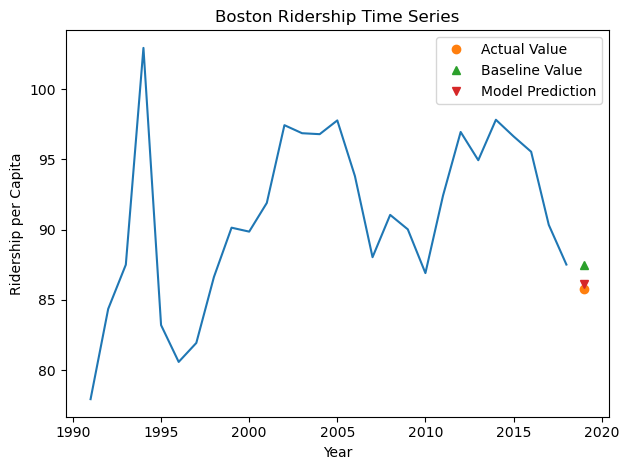

In [4]:
city_info = pd.read_csv('../data/Cities.csv', index_col='UACE Code', dtype={'UACE Code': str})

boston_code = city_info[city_info['Primary UZA Name'] == 'Boston, MA--NH'].index[0]



city = boston_code
xnames = ['Year','VRH_percap', 'OpExp_GA_frac', 'OpExp_VM_frac', 'OpExp_VO_frac', 'FedFund_frac', 'StateFund_frac', 'LocalFund_frac']
ynames = ['UPT_percap']
ydfs = [import_training_data('%s.csv' % name) for name in ynames]
city_yvals = combine_city_data(city, ydfs, ynames)

xdfs = [import_training_data('%s.csv' % name) for name in xnames]
city_xvals = combine_city_data(city, xdfs, xnames)

ynames_test = ['UPT_percap']
ydfs_test = [import_testing_data('%s.csv' % name) for name in ynames_test]
city_yvals_test = combine_city_data(city, ydfs_test, ynames_test)

xnames_test = ['Year','VRH_percap', 'OpExp_GA_frac', 'OpExp_VM_frac', 'OpExp_VO_frac', 'FedFund_frac', 'StateFund_frac', 'LocalFund_frac']
xdfs_test = [import_testing_data('%s.csv' % name) for name in xnames]
city_xvals_test = combine_city_data(city, xdfs_test, xnames_test)

lasso_pipe = Pipeline([
    ('scale', StandardScaler()),  
    ('lasso', LassoCV(alphas=None, cv=5, max_iter=100000))  
])


y = city_yvals.values.ravel()
X = city_xvals.values




yt = city_yvals_test.values.ravel()
Xt = city_xvals_test.values

lasso_pipe.fit(X, y)

prediction = lasso_pipe.predict(Xt)

baseline = y[-1]

print("The LASSO Regression coefficients are:")
print(lasso_pipe.named_steps['lasso'].coef_)



print('The 2019 test value for ridership per capita is:', yt[0])
print('The predicted 2019 value for ridership per capita is:', prediction[0])
print('The baseline 2019 value for ridership per capita is:', baseline)


plt.plot(X[:,0],y)
plt.plot(2019,yt,'o',label='Actual Value')
plt.plot(2019,baseline,'^',label='Baseline Value')
plt.plot(2019,prediction,'v',label='Model Prediction')
plt.ylabel('Ridership per Capita')
plt.xlabel('Year')
plt.title('Boston Ridership Time Series')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/Boston_Ridership',dpi=300)

For the city of Boston, MA, we find that the areas where the city may improve and have the largest affect on ridership are: spending more on vehicle maintenance, and asking for federal and local funding. Our model also provides a closer prediction to the 2019 real value than the baseline model that uses the naive forecast Gaussian Walk model.

We now turn to applying our model to all cities.

Since our data does not have trends and varies between city we decide to set our baseline model to a Gaussian Walk Model where we predict with the Naive Forecast. This means that our predicted value will be the last observed value and in our case, the values for 2018.



Below we implement a multiple linear regression model with LASSO regression using LassoCV from sklearn-linear_model

In [5]:
xnames = ['Year','VRH_percap', 'OpExp_GA_frac', 'OpExp_VM_frac', 'OpExp_VO_frac',  'FedFund_frac', 'StateFund_frac', 'LocalFund_frac']
city_info = pd.read_csv('../data/Cities.csv', index_col='UACE Code', dtype={'UACE Code': str})
pass_list = []

for idx, (index, row) in enumerate(city_info.iterrows()):
    city = index

    ynames = ['UPT_percap']#, 'PMT_percap', 'FARES_infladj_percap']
    ydfs = [import_training_data('%s.csv' % name) for name in ynames]
    city_yvals = combine_city_data(city, ydfs, ynames)

    
    xdfs = [import_training_data('%s.csv' % name) for name in xnames]
    city_xvals = combine_city_data(city, xdfs, xnames)



    ynames_test = ['UPT_percap']#, 'PMT_percap', 'FARES_infladj_percap']
    ydfs_test = [import_testing_data('%s.csv' % name) for name in ynames_test]
    city_yvals_test = combine_city_data(city, ydfs_test, ynames_test)

    
    xnames_test = ['Year','VRH_percap', 'OpExp_GA_frac', 'OpExp_VM_frac', 'OpExp_VO_frac',  'FedFund_frac', 'StateFund_frac', 'LocalFund_frac']
    xdfs_test = [import_testing_data('%s.csv' % name) for name in xnames]
    city_xvals_test = combine_city_data(city, xdfs_test, xnames_test)


    y = city_yvals.values.ravel()
    X = city_xvals.values

    yt = city_yvals_test.values.ravel()
    Xt = city_xvals_test.values

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)  # filter out nans
    X = X[mask]
    y = y[mask]
 


    
    if len(y) > 0 and X.shape[1] == len(xnames):  # make sure they aren't empty after filtering
        splits = 5
        if len(y) > splits-1: # can't have less samples than splits
            lasso_pipe = Pipeline([
                ('scale', StandardScaler()),  
                ('lasso', LassoCV(alphas=None, cv=splits, max_iter=100000))  
            ])

            
            lasso_pipe.fit(X, y)

            prediction = lasso_pipe.predict(Xt)
   
            #baseline = y.mean() # Using mean
            baseline  = y[-1]   # random wake baseline

            if (abs(prediction-yt)) < (abs(baseline-yt)):
                pass_list.append(1)

            if (abs(prediction-yt)) > (abs(baseline-yt)):
                pass_list.append(0)
            
            if (abs(prediction-yt)) == (abs(baseline-yt)):
                pass_list.append(2)


print('Number of times the model performs better than baseline:', pass_list.count(1))
print('Number of times the model performs worse than baseline:', pass_list.count(0))
print('Number of times the model performs equal to the baseline:',pass_list.count(2))

Number of times the model performs better than baseline: 36
Number of times the model performs worse than baseline: 146
Number of times the model performs equal to the baseline: 0


We find that for the majority of cities the baseline model has a closer prediction than our model.

There are variety of reasons why the improved model is not performing better than the baseline in most cities: One is that ridership is relatively flat with time in comparison to the features that go into the model such as adminstration funding and local city funding. Some of these features may have time lags in that it may take a while before the effects of for example increased funding, can affect ridership. Another factor is that the data is relatively limited in that there are at most 28 years of data and for some cities data may be missing.

These compounded factors are the reason why we moved on to creating an all cities model that has the luxury of using more data. 

